In [70]:
from qiskit import *
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
simulator = AerSimulator()

import numpy as np
from numpy.linalg import matrix_power
import math
import random

from sympy import Matrix
from sympy.physics.quantum import TensorProduct

import matplotlib.pyplot as plt

%run QuantumFourierTransform.ipynb

In [71]:
H = math.sqrt(2)/2 * np.array([[1,1],
                               [1,-1]])

In [72]:
def GenQki(A,index, ki):
    S0 = np.identity(len(A))
    S0[0][0]=-1
    
    SI = np.identity(len(A))
    SI[index][index] = -1
    
    A_dag = np.conjugate(A)
    A_dag = np.transpose(A_dag)
    
    Q = A@S0@A_dag@SI
    Qki = matrix_power(Q,ki)
    
    return UnitaryGate(Qki,label=f'Q_{ki}')

In [73]:
# https://arxiv.org/pdf/1912.05559
# Finds k_{i+1} given k_i
def FindNextK(k,lower,upper,up):
    r=2
    K_i = 4*k+2 # Current theta factor
    t_min = K_i * lower
    t_max = K_i * upper
    
    K_max = math.floor(math.pi/(upper-lower))
    K = K_max - (K_max-2)%4
    
    while K >= r*K_i:
        q = K/K_i
        
        if ((q*t_max)%(2*math.pi) <= math.pi) and ((q*t_min)%(2*math.pi) <= math.pi):
            K_i1 = K
            up_i1 = True
            k_i1 = (K_i1-2)/4
            return [k_i1,up_i1]
        
        if ((q*t_max)%(2*math.pi) <= math.pi) and ((q*t_min)%(2*math.pi) <= math.pi):
            K_i1 = K
            up_i1 = False
            k_i1 = (K_i1-2)/4
            return [k_i1,up_i1]
        
        K = K-4
         
    return k,up

In [222]:
# Use Chernoff-Hoeffding confidence interval

def IQAE(A,index,epsilon, alpha, N_shots):
    i = 0
    k_i = 0
    up_i = True
    [lower,upper] = [0,0.5*math.pi]
    Time = math.ceil(math.log(math.pi/(8*epsilon),2))
    L_max = np.arcsin((2/N_shots)*(math.log(2*Time/alpha)))**0.25
    
    while upper - lower >= 2*epsilon:
        i = i+1
        k_i,up_i = FindNextK(k_i,lower,upper,up_i)
        Ki = 4*k_i+2
        
        if Ki > math.ceil(L_max/epsilon):
            N = math.ceil(N_shots*L_max/(epsilon/(Ki/10)))
        else:
            N = N_shots
            
        # approximate a_i = P(|1>) for the last qubit of Q^{k_i}A|0>_n|0> by measuring N times
        Qki = GenQki(A,index,k_i)
        test_circuit = QuantumCircuit(len(A),1)
        test_circuit.append(Qki,[0,len(A)-1])
        test_circuit.measure(len(A)-1,0)
        
        job = transpile(test_circuit,backend=simulator)
        result = simulator.run(job, shots=N_shots).result()
        
        try:
            a_i = result.data(test_circuit)['counts'][hex(1)]/N_shots
        except:
            a_i = 0
        
        epsilon_ai = math.sqrt((1/(2*N))*math.log(2*Time/alpha))
        ai_max = min(1,a_i+epsilon_ai)
        ai_min = max(0,a_i-epsilon_ai)
        
        theta_imax = np.arccos(1-2*ai_max)/Ki
        theta_imin = np.arccos(1-2*ai_min)/Ki
        print(theta_imin,theta_imax)
        
        lower = ((math.floor(Ki*lower)%(2*math.pi))+theta_imin)/Ki
        upper = ((math.floor(Ki*upper)%(2*math.pi))+theta_imax)/Ki
        print(lower,upper)
        print(Ki, "\n")
        
    [a_l,a_u] = [np.sin(lower)**2,np.sin(upper)**2]
        
    return ai_min,ai_max

In [223]:
# Epsilon can't be greater than 0.39
IQAE(H1,1,0.25,.9,2)

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 

0.0 0.7320935373976803
0.0 1.8660467686988402
2 



KeyboardInterrupt: 

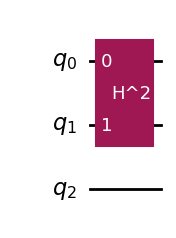

In [96]:
n=3
qc = QuantumCircuit(n)
H1 = TensorProduct(H,H)
H2 = UnitaryGate(H1, label="H^2")
qc.append(H2,[0,1])

qc.draw(output='mpl')